# Problem Set 3
## Dawei Wang (dwang56)
## Problem 1

In [39]:
import os
import glob
import random

import numpy as np

from PIL import Image

from scipy import signal
from scipy.io import wavfile
from scipy.special import expit as sigmoid

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import io
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [16]:
def gaussian_pdf(X, mean, cov):
    cInv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    pdf = np.exp((-0.5 * (X - mean).T @ cInv @ (X - mean))) / np.sqrt((2 * np.pi) ** X.shape[0] * det) 
    return pdf

class PCA(object):
    def transform(self, X, dim, full_matrices = True):
        _, S, V = np.linalg.svd(X - X.mean(0), full_matrices=full_matrices)
        idx = S.argsort()[::-1][:dim]
        self.weight = V[idx].T

        return X @ self.weight
    
    def predict(self, X):
        return X @ self.weight


class LogisticRegression(object):
    def fit(self, X, y, n_iter=1000, lr=5e-4):
        self.w = np.random.rand(X.shape[1])
        for _ in range(n_iter):
            self.w -= lr * (self.predict(X) - y).dot(X)
    def predict(self, X):
        return sigmoid(X.dot(self.w))

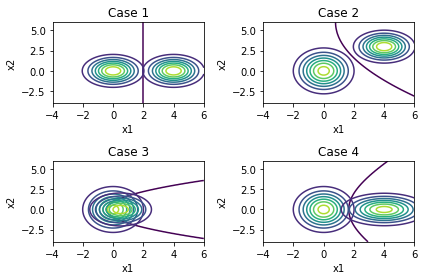

In [3]:
# Initialize data set
m1 = [ np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2) ];
C1 = [ np.diag([1,1]), np.diag([1,2]), np.diag([1,2]), np.diag([1,2]) ];
m2 = [ np.array([4,0]), np.array([4,3]), np.array([0.5,0]), np.array([4,0]) ];
C2 = [ np.diag([1,1]), np.diag([1,1]), np.diag([1,1]), np.diag([2,1]) ];

# Generate X
res = 100
x, y = np.meshgrid(np.linspace(-4, 6, res), np.linspace(-4, 6, res))
X = np.concatenate((x.reshape(1, res ** 2), y.reshape(1, res ** 2)), 0).T

for i in range(len(m1)):
    # Calculate gaussian pdf
    pdf1 = np.zeros(X.shape[0], dtype=np.float32)
    pdf2 = np.zeros(X.shape[0], dtype=np.float32)
    
    for j in range(X.shape[0]):
        pdf1[j] = gaussian_pdf(X[j], m1[i], C1[i])
        pdf2[j] = gaussian_pdf(X[j], m2[i], C2[i])

    # plot pdf & discriminant function
    ax = plt.subplot(2, 2, i + 1)
    ax.contour(x, y, (pdf1 - pdf2).reshape(res,res), levels = [0])
    ax.contour(x, y, pdf1.reshape(res,res))
    ax.contour(x, y, pdf2.reshape(res,res))
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Case ' + str(i+1))
    
plt.tight_layout()

## Problem 2

In [36]:
class GaussianClassifier(object):
    def pdf(self, X, mean, cov):
        cInv = np.linalg.inv(cov)
        det = np.linalg.det(cov)
        pdf = np.exp((-0.5 * (X - mean).T @ cInv @ (X - mean))) / np.sqrt((2 * np.pi) ** X.shape[0] * det) 
        return pdf

    def parameters(self, X):
        N, d = X.shape
        mean = np.mean(X, axis = 0)
        cov = (X-mean).T @ (X-mean) / (N - 1)
        self.mean.append(mean)
        self.cov.append(cov)
        
    def fit(self, X, y):
        self.classes = np.unique(y).shape[0]
        self.mean = []
        self.cov = []
        
        for i in range(self.classes):
            idx = np.where(y == i)[0]
            self.parameters(X[idx])
        
        return self
        
    def predict(self, X, raw = False):
        N, d = X.shape
        pred = np.empty((N, self.classes), dtype='f')
        
        for i in range(N):
            for j in range(self.classes):
                pred[i, j] = self.pdf(X[i], self.mean[j], self.cov[j])
        
        if not raw:
            return pred.argmax(axis = 1)
        else:
            return pred
    
    def evaluate(self, y, y_pred):
        return np.sum(y == y_pred) / y.shape[0]

def data_loader_p2(file, classes = 10):
    npz = np.load(file)
    data = npz['d.npy'].T
    label = npz['l.npy']
    
    trainD, trainL, testD, testL = [], [], [], []

    for i in range(classes):
        idx = np.where(label == i)[0]
        
        trainD.extend(data[idx[100:]])
        trainL.extend(label[idx[100:]])
        testD.extend(data[idx[:100]])
        testL.extend(label[idx[:100]])
    
    trainD = np.array(trainD)
    trainL = np.array(trainL)
    testD = np.array(testD)
    testL = np.array(testL)
    
    return trainD, trainL, testD, testL

In [134]:
file = './digits-labels.npz'

trainD, trainL, testD, testL = data_loader_p2(file)

accuracy = np.zeros((100))
for dim in range(1, 101, 5):
    # Dimension reduction
    pca = PCA()
    trainX = pca.transform(trainD, dim)
    testX = pca.predict(testD)

    # train & predict
    g = GaussianClassifier()
    g.fit(trainX, trainL)
    predL = g.predict(testX)
    accuracy[dim-1] = g.evaluate(testL, predL)


Best accuracy at dimension:  31 , the accuracy is:  0.952


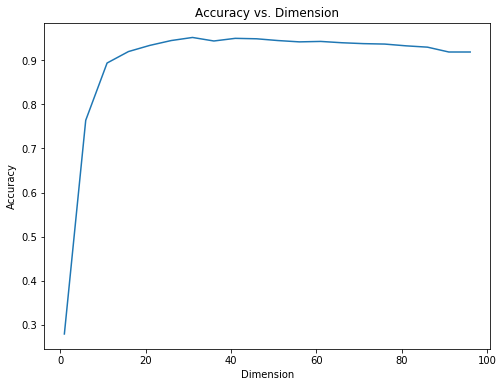

In [136]:
acc = accuracy[np.nonzero(accuracy)]
best_dim = np.argmax(accuracy) + 1

fig, ax = plt.subplots(figsize=(8, 6))
print("Best accuracy at dimension: ", best_dim, ", the accuracy is: ", accuracy[best_dim-1])
ax.plot(np.arange(1, 101, 5), acc)
ax.set_title('Accuracy vs. Dimension')
ax.set_xlabel('Dimension')
ax.set_ylabel('Accuracy')

plt.show()

### Conclusion
We trained based on 1 - 100 dimensions after reduction from PCA. From the image above, we can see that the accuracy are all above 90% and the best accuracy occurs at about dimension 31.

## Problem 3

In [35]:
def data_loader_p3(directory, norm = 1e-5):
    # Get all file path
    paths = glob.glob(directory + "*.wav")
    
    data = []
    overlap = 0
    window_size = 1024
    train_test_split = 0.1
    
    # Read all wav files from directory
    for p in paths:
        fs, sound = wavfile.read(p)
        sound = sound.astype('float32')
        
        # Apply spectrogram alalysis
        f, t, Sxx = signal.spectrogram(sound, fs, window = signal.get_window('hamming',window_size), nperseg = window_size, noverlap= overlap, scaling='spectrum')
        data.append(np.log(np.absolute(f)) + norm)
#         data.append(np.absolute(Sxx))
    
    # Split training and testing data set
    split_idx = int(train_test_split * len(data))
    test = np.hstack(data[: split_idx])
    train = np.hstack(data[split_idx :])
    
    return train.T, test.T

In [51]:
directory = "./SpeechMusic/"

# Load data
trainM, testM = data_loader_p3(directory + "music/")
trainS, testS = data_loader_p3(directory + "speech/")
trainX = np.concatenate((trainM, trainS), axis = 0)
testX = np.concatenate((testM, testS), axis=0)

trainL = np.zeros((trainM.shape[0] + trainS.shape[0]), dtype=int)
trainL[trainS.shape[0]:] = 1
testL = np.zeros((testM.shape[0] + testS.shape[0]), dtype=int)
testL[testS.shape[0]:] = 1

# Dimension reduction
pca = PCA()
trainX = pca.transform(trainX, 40, full_matrices = False)
testX = pca.predict(testX)

g = GaussianClassifier().fit(trainX, trainL)
predL = g.predict(testX, raw = False)
print("The test accuracy is: ", g.evaluate(testL, predL)) 

pred = g.predict(testX, raw = True)


The test accuracy is:  0.9428071364046974


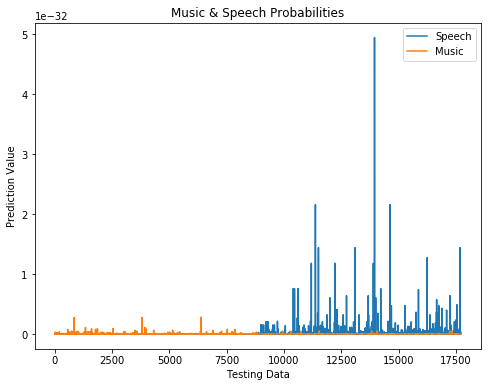

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
music, speech = pred[:,0], pred[:,1]
x_axis = np.arange(music.shape[0])
ax.plot(x_axis, speech, label='Speech')
ax.plot(x_axis, music, label='Music')
ax.legend()

ax.set_title('Music & Speech Probabilities')
ax.set_xlabel('Testing Data')
ax.set_ylabel('Prediction Value')

plt.show()

### Concolsion
From this image above, we can see clearly that our gaussian classifier predict different value between speech and music. 

## Problem 4

For this problem, we first label the swimming pool on the map image manually and load the image in YCbCr color space.

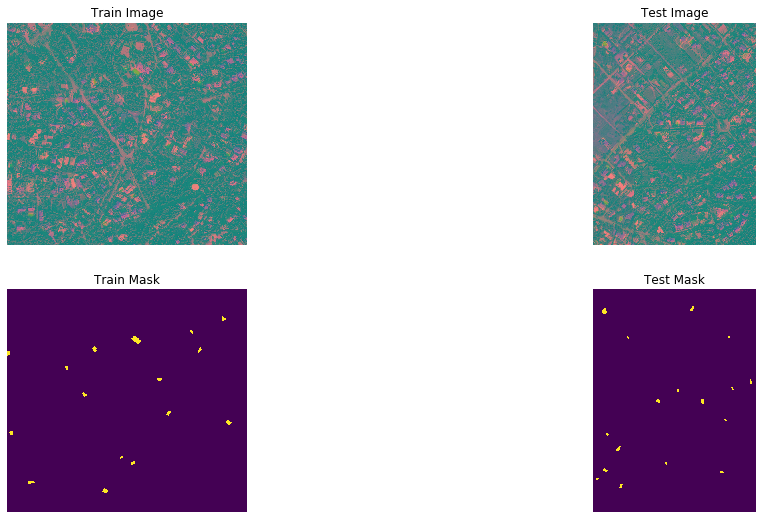

In [23]:
# load data
trainImg = np.array(Image.open('./ekalismall.png', 'r').convert('YCbCr'))
testImg = np.array(Image.open('./ekalismall2.png', 'r').convert('YCbCr'))
trainMask = np.load('./train_mask.npy')
testMask = np.load('./test_mask.npy')

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 9))

ax[0,0].axis('off')
ax[0,0].set_title('Train Image')
ax[0,0].imshow(trainImg)

ax[0,1].axis('off')
ax[0,1].set_title('Test Image')
ax[0,1].imshow(testImg)

ax[1,0].axis('off')
ax[1,0].set_title('Train Mask')
ax[1,0].imshow(trainMask)

ax[1,1].axis('off')
ax[1,1].set_title('Test Mask')
ax[1,1].imshow(testMask)

plt.show()

The next step is to generate bounding boxes for each swimming pool on the map. On the image below, I labeled each pool by red rectangles.

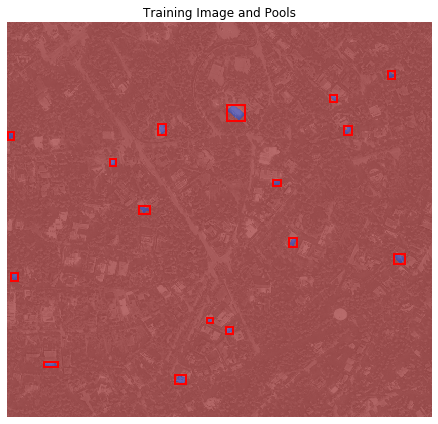

In [24]:
# Generate bounding box
label_image = label(trainMask)
image_label_overlay = label2rgb(trainMask, image=trainImg)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

boxes = []
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 60:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        boxes.append(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_title('Training Image and Pools')
ax.set_axis_off()
plt.tight_layout()
plt.show()

Then using the bounding box, we can generate our training and testing images. We select only the Cb channel since it has pretty good performance to detect blue color which is the color for swimming pools.
We apply a 10 * 10 sliding window on training image to generate data. Data for swimming pools are generate inside bounding boxes and data for not swimming pools are generated randomly elsewhere.

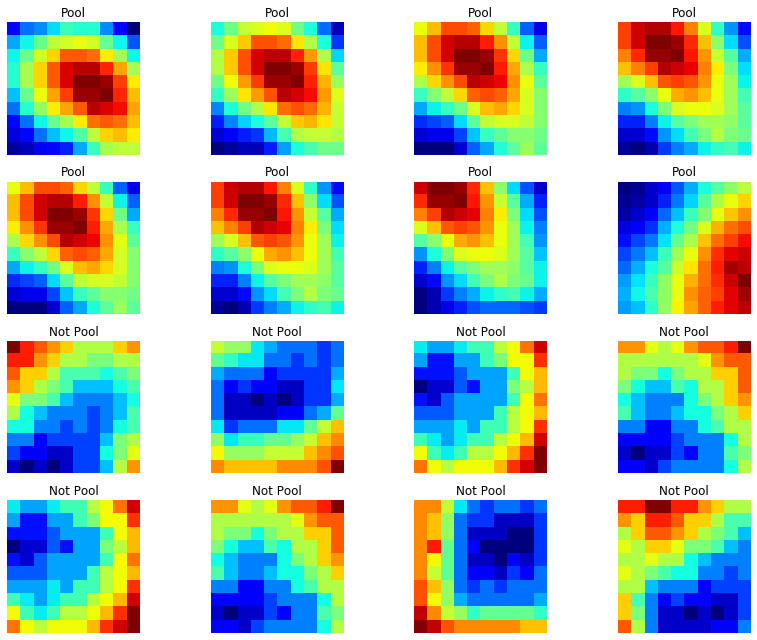

In [25]:
# Generate training data
box_size = 10
trainCb = trainImg[:, :, 1]
upper_threshold = 142
lower_threshold = 115
# print(trainCb.shape) # r, c

trainX = []
trainY = []
for minr, minc, maxr, maxc in boxes:
    row, col = 0, 0
    while minr + row < maxr and col + minc < maxc:
        row_idx = minr + row
        col_idx = minc + col
        img = trainCb[row_idx:row_idx+box_size, col_idx:col_idx+box_size]
        
        if np.average(img) > upper_threshold:
            trainX.append(img)
            trainY.append(1)
        
        row = row + 1
        col = col + 1

size = len(trainX)

while len(trainX) < size * 2:
    r = np.random.randint(low=600, high=770, size=1)[0]
    c = np.random.randint(low=600, high=829, size=1)[0]
    img = trainCb[r:r+box_size, c:c+box_size]
    
    if np.mean(img) < lower_threshold:
        trainX.append(img)
        trainY.append(0)
    
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(trainX[i*2+j], cmap='jet')
        ax[i,j].set_axis_off()
        ax[i,j].set_title('Pool')

for i in range(2, 4):
    for j in range(4):
        ax[i,j].imshow(trainX[i*2+j+75], cmap='jet')
        ax[i,j].set_axis_off()
        ax[i,j].set_title('Not Pool')

plt.tight_layout()
plt.show()

In [26]:
# Generate testing data
testCb = testImg[:, :, 1]
upper_threshold = 136

testX = []
testPos = []
for r in range(testCb.shape[0] - box_size):
    for c in range(testCb.shape[1] - box_size):
        img = testCb[r:r+box_size, c:c+box_size]
        if np.average(img) > upper_threshold:
            testX.append(img)
            testPos.append((r,c))

testX = np.array(testX)
testX = np.reshape(testX, (testX.shape[0],-1))
testPos = np.array(testPos)

After generate the data, we can train it using logistic regression classification method.

In [27]:
# Shuffle data
idx = np.random.permutation(len(trainX))
trainX, trainY = np.array(trainX)[idx], np.array(trainY)[idx]
trainX = np.reshape(trainX, (trainX.shape[0],-1))
trainY = trainY.flatten()

# Training
logreg = LogisticRegression()
logreg.fit(trainX, trainY)
predY = np.rint(logreg.predict(testX))

Finally, we apply a 10 * 10 sliding window on testing image and make prediction based on our classifier. Based on this result, we can generate new bounding boxes for pools on testing image and generate final output below.

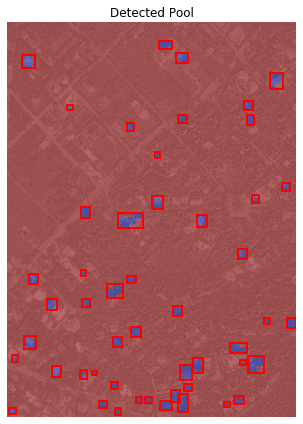

In [28]:
# Make prediction
idx = np.where(predY == 1)
idx = np.asarray(idx).flatten()
pool = testPos[idx]

predImg = np.zeros_like(testCb)
for i in range(pool.shape[0]):
    r, c = pool[i]
    predImg[r:r+box_size, c:c+box_size] = 1

# Apply predicted mask to test image
label_image = label(predImg)
image_label_overlay = label2rgb(predImg, image=testImg)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

boxes = []
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 60:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        boxes.append(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_title('Detected Pool')
ax.set_axis_off()
plt.tight_layout()
plt.show()